In [1]:
import os
import sys
import pickle
from human_eval.data import HUMAN_EVAL, read_problems, stream_jsonl, write_jsonl
import numpy as np
import pickle
from tqdm import trange
from sklearn.model_selection import KFold, StratifiedGroupKFold
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kendalltau

In [2]:
NUM_TASKS = 510

In [3]:
def calc_mtd(dgms):
    dgm0 = dgms[0]
    dgm1 = dgms[1]
    
    mtd0 = np.sum(dgm0[dgm0 < np.inf])
    if dgm1.shape[0]:
        mtd1 = np.sum(dgm1[:, 1] - dgm1[:, 0])
    else:
        mtd1 = 0
    
    return mtd0, mtd1

In [4]:
(results, results_code) = pickle.load(open('/mbpp_results2/all.pickle', 'rb'))

In [5]:
#pickle.dump((results, results_code), open('/mbpp_results2/all.pickle', 'wb'))

results = {}
results_code = {}

for i in trange(10, 510):
    results1, results_code1 = pickle.load(open('/mbpp_results2/%d.pickle' % i, 'rb')), pickle.load(open('/mbpp_results2/%d_code.pickle' % i, 'rb'))

    for k, v in results1.items():
        dgms_a, dgms_b = v[-2]['dgms'], v[-1]['dgms']
        results1[k] = v[:4] + [calc_mtd(dgms_a), calc_mtd(dgms_b)]

    results.update(results1)
    results_code.update(results_code1)

In [6]:
samples = []
num_samples_per_task = 1

for task_num in trange(10, 510):        
    task_id = 'MBPP/%d' % task_num
    samples.append(dict(task_id = task_id, completions = results_code[(task_id, 0)][0]))

100%|██████████| 500/500 [00:00<00:00, 375497.22it/s]


In [7]:
write_jsonl("mbpp_samples.jsonl", samples)

In [8]:
!python evaluate_mbpp.py

test_program
------------

def remove_Occ(s, x):
  t = s
  t = t.replace(x, "")
  if t[0] == x:
    t = t[1:]
  if t[-1] == x:
    t = t[:-1]
  return (t)

assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
test_program
------------

def remove_Occ(s,c):
  res = s.replace(c,"",1).replace(c,"",-1)
  return(res)

assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
test_program
------------

def remove_Occ(test, char):
  if test.count(char) >= 2:
    test = test.replace(test[0], "", 1)
    test = test.replace(test[-1], "", 1)
  return (test)

assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
test_program
------------

def remove_Occ(s,c):
  return s[1:-1] 

assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
test_program
------------


In [18]:
run_stat = [[] for _ in range(NUM_TASKS)]
run_results = [[] for _ in range(NUM_TASKS)]

for elem in stream_jsonl('mbpp_evaluation.jsonl'):
    task_id = elem['task_id']
    task_num = int(task_id.split('/')[-1])

    run_stat[task_num].append([int(x[1]['passed']) for x in elem['results']])
    run_results[task_num].append([x[1]['result'] for x in elem['results']])

In [19]:
errors = set([])

for elem in run_results:
    if elem:
        errors = errors | set(elem[0])

In [20]:
errors

{'failed: AssertionError',
 'failed: AttributeError',
 'failed: IndentationError',
 'failed: IndexError',
 'failed: ModuleNotFoundError',
 'failed: NameError',
 'failed: RecursionError',
 'failed: SyntaxError',
 'failed: TypeError',
 'failed: UnboundLocalError',
 'failed: ValueError',
 'failed: ZeroDivisionError',
 'passed',
 'timed out'}

In [12]:
errors_code = {}

for i, e in enumerate(sorted(errors)):
    errors_code[e] = i

In [13]:
errors_code

{'failed: AssertionError': 0,
 'failed: AttributeError': 1,
 'failed: IndentationError': 2,
 'failed: IndexError': 3,
 'failed: ModuleNotFoundError': 4,
 'failed: NameError': 5,
 'failed: RecursionError': 6,
 'failed: SyntaxError': 7,
 'failed: TypeError': 8,
 'failed: UnboundLocalError': 9,
 'failed: ValueError': 10,
 'failed: ZeroDivisionError': 11,
 'passed': 12,
 'timed out': 13}

In [14]:
#problems = pickle.load(open('/hcode/mbpp_problems.pickle', 'rb'))

In [15]:
#all_code = []
#
#for elem in samples:
#    for c in elem['completions']:
#        all_code.append(problems[elem['task_id']]['prompt'] + c + '[DONE]')

In [16]:
#pickle.dump(all_code, open('/mbpp_results2/code.pickle', 'wb'))

In [17]:
#pickle.dump(Y, open('/mbpp_results2/Y.pickle', 'wb'))

In [18]:
#data = [prompt_len, correct_prefixes[seq], torch.sum(torch.diag(a_matrix)[:prompt_len]).item(), torch.sum(torch.diag(a_matrix)[prompt_len:]).item()]
#data.extend([probs, calc_mtd(a_matrix, prompt_len, kind = 0), calc_mtd(a_matrix, prompt_len, kind = 1)])
#results[(task_id, seed, seq, layer, head)] = data

### Random split

In [21]:
Y = []

for elem in stream_jsonl('mbpp_evaluation.jsonl'):
    task_id = elem['task_id']
    task_num = int(task_id.split('/')[-1])

    Y.extend([int(x[1]['passed']) for x in elem['results']])
    #Y.extend([errors_code[x[1]['result']] for x in elem['results']])

In [22]:
np.sum(Y), np.mean(Y)

(879, 0.3516)

In [23]:
len(Y) - np.sum(Y)

1621

In [24]:
def get_probs():
    all_probs = []

    for task_num in range(10, 510):
        features = []
        task_id = 'MBPP/%d' % task_num
        for seed in range(1):
            for seq in range(5):

                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                probs = results_code[(task_id, 0)][2][seq]
                probs = probs[prompt_len:prompt_len + answer_len]
                        
                all_probs.append(np.mean(np.log(probs)))
    
    return np.array(all_probs)

In [25]:
all_probs = get_probs()

In [26]:
def prepare_features():
    all_features = []

    for task_num in trange(10, 510):
        features = []
        task_id = 'MBPP/%d' % task_num
        for seed in range(1):
            for seq in range(5):

                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                f_sample = [prompt_len, answer_len]
                                
                for layer in range(32):
                    for head in range(32):
                        f = results[(task_id, seed, seq, layer, head)]
                        f = [f[2] / prompt_len, f[3] / answer_len, f[4][0] / answer_len, f[4][1] / answer_len, f[5][0] / prompt_len , f[5][1] / prompt_len]
                        f_sample.extend(f)
                        
                all_features.append(f_sample)
    
    return all_features

In [27]:
f_names = ['prompt_len', 'answer_len']
cnt = 2

f = ['prompt_self_att', 'answer_self_att', 'mtd_a_h0', 'mtd_a_h1', 'mtd_b_h0', 'mtd_b_h1']
        
for layer in range(32):
    for head in range(32):
        for f1 in f:
            f_names.append('%d_%s_%d_%d' % (cnt, f1, layer, head))
            cnt += 1

In [28]:
len(f_names)

6146

In [29]:
X = prepare_features()
X = np.array(X)
Y = np.array(Y)

100%|██████████| 500/500 [00:46<00:00, 10.71it/s]


In [30]:
X.shape, len(Y)

((2500, 6146), 2500)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### XGBoost

### Transfer learning

In [31]:
X.shape

(2500, 6146)

In [32]:
X = np.concatenate((X, all_probs.reshape((X.shape[0], 1))), axis = 1)
#X = all_probs.reshape((X.shape[0], 1))

In [33]:
X.shape

(2500, 6147)

In [34]:
%%time

clf = xgb.XGBClassifier(tree_method="hist", max_bin = 64, n_estimators = 1000, eta = 0.1).fit(X, Y)
#clf = xgb.XGBClassifier(tree_method="hist").fit(X, Y)
clf.save_model('mbpp.xgb')

CPU times: user 42min 55s, sys: 2min 39s, total: 45min 35s
Wall time: 1min 8s


/home/anaconda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:56:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [35]:
clf.load_model('he.xgb')

In [36]:
roc_auc_score(Y, clf.predict_proba(X)[:,1])

0.773471620700715

In [37]:
f1_score(Y, clf.predict(X))

0.017997750281214846

### Cross-validate XGBoost

In [38]:
clf_obj = xgb.XGBClassifier(tree_method="hist", max_bin = 64)
cv_res = cross_validate(clf_obj, X, Y, scoring = 'roc_auc', cv = KFold(n_splits = 5, shuffle = True, random_state = 42))

In [39]:
np.mean(cv_res['test_score'])

0.8955901541250793

### Feature importance

In [32]:
clf = xgb.XGBClassifier(tree_method="hist").fit(X_train, y_train)

In [33]:
for elem in sorted(list(enumerate(zip(clf.feature_importances_, f_names))), key = lambda x : -abs(x[1][0])):
    print(elem)

(3039, (0.018751638, '3039_answer_self_att_15_26'))
(2410, (0.01870091, '2410_mtd_a_h0_12_17'))
(5336, (0.012412465, '5336_prompt_self_att_27_25'))
(2521, (0.010607473, '2521_mtd_b_h1_13_3'))
(4724, (0.00989626, '4724_prompt_self_att_24_19'))
(5164, (0.00974457, '5164_mtd_a_h0_26_28'))
(3036, (0.009655064, '3036_mtd_b_h0_15_25'))
(2499, (0.009443287, '2499_answer_self_att_13_0'))
(4843, (0.00937362, '4843_mtd_b_h1_25_6'))
(2802, (0.008788657, '2802_mtd_b_h0_14_18'))
(3019, (0.008326336, '3019_mtd_b_h1_15_22'))
(4316, (0.008296175, '4316_prompt_self_att_22_15'))
(3049, (0.008161925, '3049_mtd_b_h1_15_27'))
(1680, (0.008114965, '1680_mtd_b_h0_8_23'))
(3610, (0.008114465, '3610_mtd_a_h0_18_25'))
(5283, (0.007686319, '5283_answer_self_att_27_16'))
(3694, (0.0074917115, '3694_mtd_a_h0_19_7'))
(3040, (0.0071581937, '3040_mtd_a_h0_15_26'))
(910, (0.006859138, '910_mtd_a_h0_4_23'))
(3984, (0.0063833394, '3984_mtd_b_h0_20_23'))
(6015, (0.0063230614, '6015_answer_self_att_31_10'))
(3355, (0.0062

In [34]:
import shap
explainer = shap.TreeExplainer(clf.get_booster())
shap_values = explainer.shap_values(X_test)

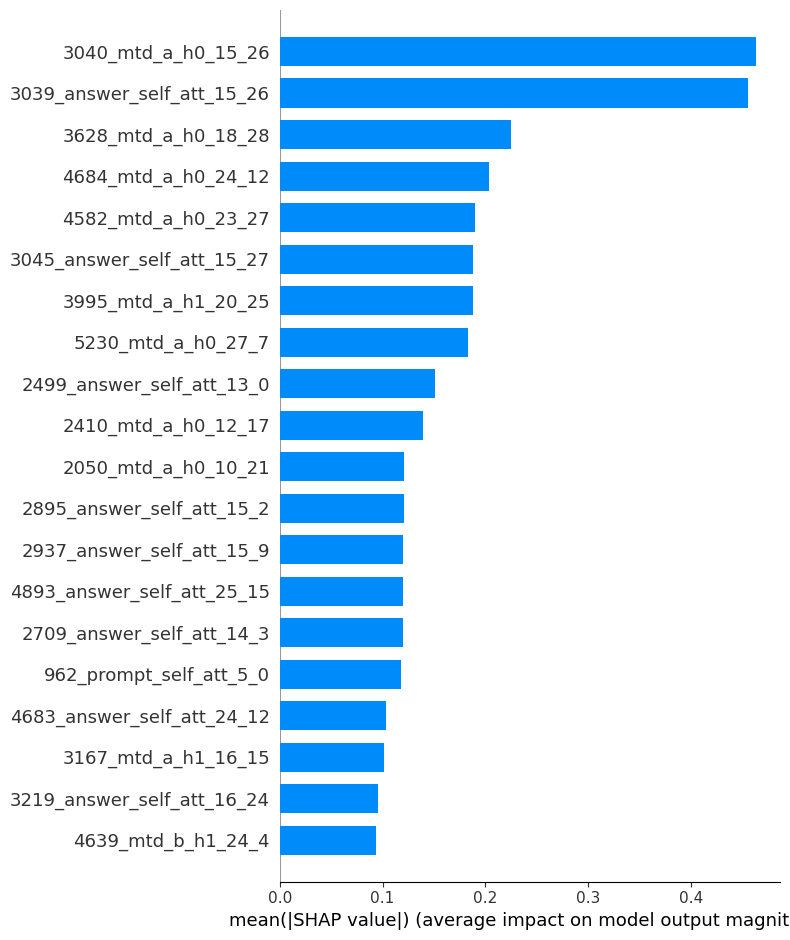

In [35]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = f_names)

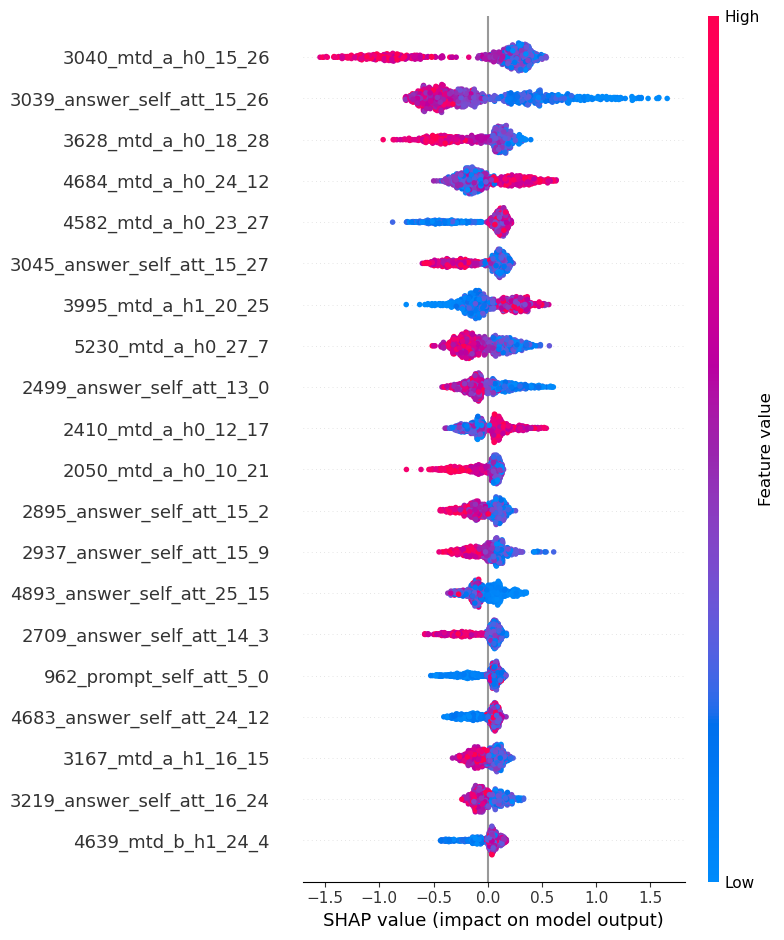

In [36]:
shap.summary_plot(shap_values, X_test, feature_names = f_names)

In [37]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

def plot5hist(num_list):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    for i in range(5):
        plot_feature_hist(axes[i], num_list[i])

def plot_feature_hist(ax, num):
    A = list(zip(X_scaled[:, num], Y))
    idx, mtd, kind, h, layer, head = f_names[num].split('_')

    if mtd == 'mtd':
        B = [z[0] for z in list(filter(lambda x : x[1] == 1, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '1')
        
        B = [z[0] for z in list(filter(lambda x : x[1] == 0, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '0')
    else:
        B = [z[0] for z in list(filter(lambda x : x[1] == 1, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '1')
        
        B = [z[0] for z in list(filter(lambda x : x[1] == 0, A))]
        ax.hist(B, bins = np.arange(0., 1., 0.05), alpha = 0.5, density = True, label = '0')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(-5, 5.1)

    ax.set_xlim(-0.01, 1.01)
    h = h[1]
    if mtd == 'mtd':
        name = 'MTD$_%s$(%s),layer=%s,head=%s' % (h, "P,G" if kind == 'a' else 'G,P', layer, head)
    else:
        name = 'sum_diag(%s),layer=%s,head=%s' % ("P" if kind == 'P' else 'G', layer, head)
    ax.set_xlabel(name)
    ax.legend(loc='best')
    #plt.show()

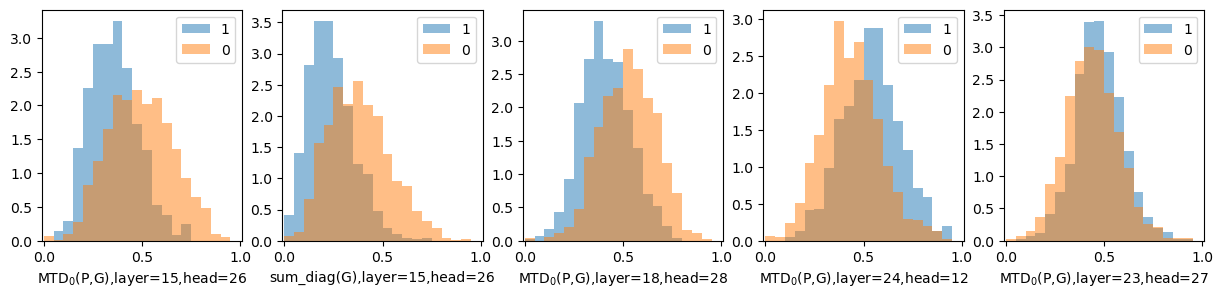

In [38]:
plot5hist([3040, 3039, 3628, 4684, 4582])

### Single feature correlations

In [39]:
data = []

def nan2zero(x):
    if np.isnan(x):
        return 0.
    else:
        return x
        
for i in range(X_train.shape[1]):
    #data.append((nan2zero(kendalltau(X_train[:, i], y_train).statistic), i, f_names[i]))
    data.append((roc_auc_score(Y, X[:, i]) - 0.5, i, f_names[i]))

#data = list(filter(lambda x : not np.isnan(x[0]), data))

In [40]:
sorted(data, key = lambda x : -np.abs(x[0]))

[(-0.2683595359260109, 3039, '3039_answer_self_att_15_26'),
 (-0.2425647028934091, 3040, '3040_mtd_a_h0_15_26'),
 (-0.22865630915058965, 3628, '3628_mtd_a_h0_18_28'),
 (0.22287363170671626, 2740, '2740_mtd_a_h0_14_8'),
 (-0.22241569165791142, 3796, '3796_mtd_a_h0_19_24'),
 (-0.21675302608889718, 3045, '3045_answer_self_att_15_27'),
 (0.21341164283623848, 3304, '3304_mtd_a_h0_17_6'),
 (-0.2038977190023714, 2500, '2500_mtd_a_h0_13_0'),
 (0.2002040201872607, 3303, '3303_answer_self_att_17_6'),
 (0.19704581295412393, 2410, '2410_mtd_a_h0_12_17'),
 (-0.19556426284986794, 2709, '2709_answer_self_att_14_3'),
 (-0.19516562691466316, 2499, '2499_answer_self_att_13_0'),
 (0.19306085724973487, 2987, '2987_mtd_a_h1_15_17'),
 (0.1929250543387101, 4684, '4684_mtd_a_h0_24_12'),
 (0.19130454311619616, 2194, '2194_mtd_a_h0_11_13'),
 (-0.18888570728752813, 2937, '2937_answer_self_att_15_9'),
 (0.18721606839694316, 4084, '4084_mtd_a_h0_21_8'),
 (0.18682655617152288, 2518, '2518_mtd_a_h0_13_3'),
 (0.18625

In [41]:
pickle.dump(data, open('mbpp_corr.pickle', 'wb'))

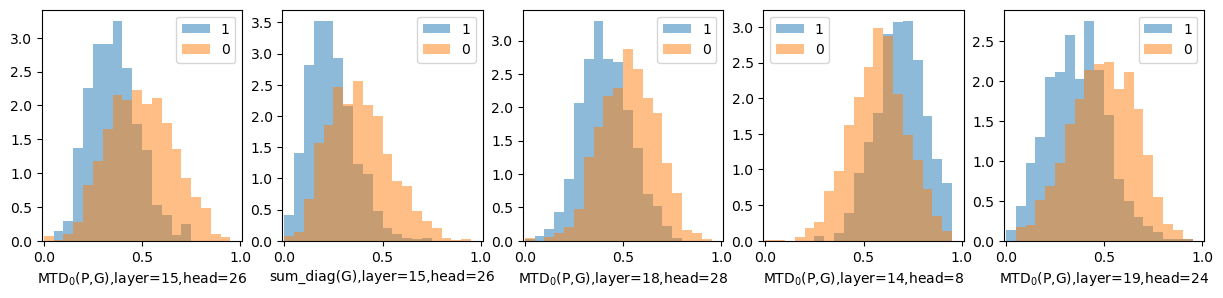

In [42]:
plot5hist([3040, 3039, 3628, 2740, 3796])

### Split by task

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [56]:
#inter_llm_mbpp_res = pickle.load(open('/hcode/inter_llm_mbpp_res.pickle', 'rb'))
#X = np.array(inter_llm_mbpp_res[50:]).reshape((len(inter_llm_mbpp_res)-50, 1))

In [57]:
#self_eval_mbpp_res = pickle.load(open('/hcode/self_eval_mbpp_res.pickle', 'rb'))[50:]
#X = np.array([int(x == 'A') for x in self_eval_mbpp_res]).reshape((len(self_eval_mbpp_res), 1))

In [63]:
def get_opt_threshold(X, Y):

    best_t = 0.5
    best_f1 = -float('inf')
    
    for t in np.arange(0.5, 0.9, 0.001):
        pred = X > t
        f1 = f1_score(Y, pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

In [64]:
def calc_quality_group(train_idx, test_idx):

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    probs_train = []
    probs_test = []

    test_info = []
    test_task_nums = set()
    
    for i in range(X.shape[0]):
        if i in train_idx:
            X_train.append(X[i])
            y_train.append(Y[i])
            probs_train.append(all_probs[i])
        else:
            X_test.append(X[i])
            y_test.append(Y[i])
            test_info.append(i // 5)
            probs_test.append(all_probs[i])

    #
    # scaling is optional
    #
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    #X_train = np.array(probs_train).reshape(len(probs_train), 1)
    #X_test = np.array(probs_test).reshape(len(probs_test), 1)
    
    print(X_train.shape)
    print(X_test.shape)

    clf = xgb.XGBClassifier(tree_method="hist", max_bin = 64, n_estimators = 100, eta = 0.1)
    #clf = MLPClassifier(hidden_layer_sizes=(128, 128, ), max_iter = 1000, early_stopping = True)
    #clf = LogisticRegression(max_iter=1000)
    #clf = SVC(probability=True, C = 100)
    clf.fit(X_train, y_train)    

    #y_pred = X_test[:, 2740]
    #y_pred_class = [int(x > 0.5) for x in y_pred]
    
    #thres = get_opt_threshold(X_train, y_train)
    
    y_pred = clf.predict_proba(X_test)[:,1]
    y_pred_class = clf.predict(X_test)

    #y_pred = probs_test
    #y_pred_class = [int(x > 0.5) for x in probs_test]

    #y_pred = X_test[:, 0]
    #y_pred_class = [int(y > thres) for y in X_test[:, 0]]

    #
    #
    #
    task_res = {task_num : [] for task_num in set(test_info)}

    for i in range(len(test_info)):
        task_num = test_info[i]
        p = y_pred[i]
        task_res[task_num].append((p, y_test[i]))

    all_candidates = []

    for task_num in task_res:
        pred_list = task_res[task_num]
        pred_list_sorted = sorted(pred_list, key = lambda x : -x[0])
        #best_candidate = [x[1] for x in pred_list_sorted[0:1]]
    
        all_candidates.append(pred_list_sorted)

    #return accuracy_score(y_test, y_pred > 0.5), all_candidates
    return roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred_class), all_candidates, clf

In [65]:
groups = []

for i in range(500):
    for j in range(5):
        groups.append(i)

kf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)

splits = []

for train_idx, test_idx in kf.split(range(X.shape[0]), Y, groups):
    splits.append((train_idx, test_idx))

In [66]:
#pickle.dump(splits, open('/mbpp_results2/splits.pickle', 'wb'))

In [67]:
groups = []

for i in range(500):
    for j in range(5):
        groups.append(i)

kf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = 42)
res_auc = []
res_f1 = []
all_task_res = []
all_clf = []

for train_idx, test_idx in kf.split(range(X.shape[0]), Y, groups):
    #print("%s %s" % (train_idx, test_idx))
    auc, f1, task_res, clf = calc_quality_group(train_idx, test_idx)
    res_auc.append(auc)
    res_f1.append(f1)
    all_task_res.append(task_res)
    all_clf.append(clf)

(2000, 6146)
(500, 6146)
(2000, 6146)
(500, 6146)
(2000, 6146)
(500, 6146)
(2000, 6146)
(500, 6146)
(2000, 6146)
(500, 6146)


In [68]:
np.mean(res_auc), np.std(res_auc)

(0.8352521326647551, 0.013554102775369123)

In [69]:
np.mean(res_f1), np.std(res_f1)

(0.6402728166798488, 0.0567940455122678)

In [71]:
def plot_fstr(clf_fi):

    fstr = np.zeros((32, 32))
    
    for i in range(clf_fi.shape[0]):
        if i >= 2:
            layer, head = int(f_names[i].split('_')[-2]), int(f_names[i].split('_')[-1])
            fstr[layer, head] += clf_fi[i]
    
    fig, ax = plt.subplots()
    
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    im = ax.imshow(fstr, origin = 'lower', cmap = 'Oranges')
    
    #ax.set_title('Pan on the colorbar to shift the color mapping\n'
    #             'Zoom on the colorbar to scale the color mapping')
    
    fig.colorbar(im, ax=ax, label='Feature impportance, %')
    fig.set_size_inches((4, 4))
    plt.show()

In [72]:
all_fstr = sum([x.feature_importances_ for x in all_clf]) / len(all_clf) * 100

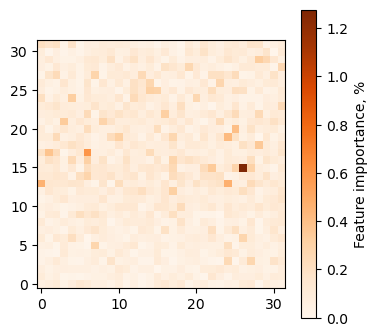

In [73]:
plot_fstr(all_fstr)

In [74]:
np.argmax(all_fstr)

3039

In [76]:
pass1 = 0
pass10 = 0
cnt = 0

pass1_list = []
pass1_fold = 0
cnt_fold = 0

for fold in all_task_res:

    pass1_fold = 0
    cnt_fold = 0
    
    for task_pred in fold:
        pass1 += task_pred[0][1]
        pass10 += max([x[1] for x in task_pred[0:10]])
        #print(task_pred[0:5])
        cnt += 1
        
        pass1_fold += task_pred[0][1]
        cnt_fold += 1

    pass1_list.append(pass1_fold / cnt_fold)

In [77]:
np.mean(pass1_list), np.std(pass1_list)

(0.43200000000000005, 0.03655133376499413)

In [78]:
pass1/cnt, pass10/cnt

(0.432, 0.594)

### Baseline

In [79]:
pass1_list = []
pass10_list = []

for k in range(10000):

    pass1 = 0
    pass10 = 0
    cnt = 0
    
    for fold in all_task_res:
        for task_pred in fold:
            np.random.shuffle(task_pred)
            pass1 += task_pred[0][1]
            pass10 += max([x[1] for x in task_pred[0:10]])
            cnt += 1

    pass1_list.append(pass1 / cnt)
    pass10_list.append(pass10 / cnt)

In [80]:
np.mean(pass1_list), np.mean(pass10_list)

(0.3516234, 0.594)

In [81]:
sorted(pass1_list)[-500]

0.374

In [82]:
sorted(pass10_list)[-500]

0.594

### Ranking

In [83]:
def calc_quality_rank(train_idx, test_idx):

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    probs_test = []

    train_info = []
    test_info = []
    
    for i in range(X.shape[0]):
        task_num = i // 5
    
        if task_num in train_idx:
            X_train.append(X[i])
            y_train.append(Y[i])
            train_info.append(task_num)
        else:
            X_test.append(X[i])
            y_test.append(Y[i])
            test_info.append(task_num)
            probs_test.append(all_probs[i])
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = xgb.XGBRanker(tree_method="hist", max_bin = 64, objective = 'rank:pairwise')
    clf.fit(X_train, y_train, qid = train_info)
    y_pred = clf.predict(X_test)

    #y_pred = probs_test
    
    #
    #
    #
    task_res = {}

    for task_num in test_idx:
        task_res[task_num] = []

    for i in range(len(test_info)):
        task_num = test_info[i]
        p = y_pred[i]
        task_res[task_num].append((p, y_test[i]))

    all_candidates = []

    for task_num in task_res:
        pred_list = task_res[task_num]
        pred_list_sorted = sorted(pred_list, key = lambda x : -x[0])
        #best_candidate = [x[1] for x in pred_list_sorted[0:1]]
    
        all_candidates.append(pred_list_sorted)

    #return accuracy_score(y_test, y_pred > 0.5), all_candidates
    return roc_auc_score(y_test, y_pred), all_candidates, clf

In [84]:
idx = list(range(X.shape[0] // 5))

kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
res = []
all_task_res = []
all_clf = []

for train_idx, test_idx in kf.split(idx):
    #print("%s %s" % (train_idx, test_idx))
    auc, task_res, clf = calc_quality_rank(train_idx, test_idx)
    res.append(auc)
    all_task_res.append(task_res)
    all_clf.append(clf)

In [85]:
print(res)

[0.6782174688057041, 0.8104032898059303, 0.695587358378056, 0.7469879518072289, 0.8043098818474759, 0.7691511387163562, 0.7427333333333334, 0.7397504456327986, 0.716537797462653, 0.7266696481812761]


In [86]:
pass1 = 0
pass10 = 0
cnt = 0

for fold in all_task_res:
    for task_pred in fold:
        pass1 += task_pred[0][1]
        pass10 += max([x[1] for x in task_pred[0:10]])
        cnt += 1

In [87]:
pass1 / cnt, pass10 / cnt

(0.444, 0.594)

In [88]:
for elem in sorted(list(enumerate(zip(all_clf[0].feature_importances_, f_names))), key = lambda x : -abs(x[1][0])):
    print(elem)

(4821, (0.022972947, '4821_answer_self_att_25_3'))
(6101, (0.018734131, '6101_mtd_a_h1_31_24'))
(5595, (0.017964467, '5595_answer_self_att_29_4'))
(693, (0.01742124, '693_answer_self_att_3_19'))
(2403, (0.017094532, '2403_answer_self_att_12_16'))
(3958, (0.017041411, '3958_mtd_a_h0_20_19'))
(1876, (0.014959922, '1876_mtd_a_h0_9_24'))
(2397, (0.01393009, '2397_answer_self_att_12_15'))
(143, (0.013213503, '143_mtd_a_h1_0_23'))
(2831, (0.013041094, '2831_mtd_a_h1_14_23'))
(2541, (0.012461613, '2541_answer_self_att_13_7'))
(3106, (0.012365366, '3106_mtd_a_h0_16_5'))
(2139, (0.011668646, '2139_answer_self_att_11_4'))
(1391, (0.011095845, '1391_mtd_a_h1_7_7'))
(1741, (0.010698245, '1741_mtd_b_h1_9_1'))
(4228, (0.009363145, '4228_mtd_a_h0_22_0'))
(1407, (0.009141922, '1407_answer_self_att_7_10'))
(1779, (0.008920682, '1779_answer_self_att_9_8'))
(3911, (0.008662061, '3911_mtd_a_h1_20_11'))
(4762, (0.008634756, '4762_mtd_a_h0_24_25'))
(3801, (0.008590416, '3801_answer_self_att_19_25'))
(5555, 

### Visualize barcodes

In [89]:
from barcodes import plot_barcodes

In [177]:
results14 = pickle.load(open('/mbpp_results2/%d.pickle' % 14, 'rb'))

H0: num barcodes 50
max0,976Barcode 0 = 0.8609619
maxBarcode 0 = inf
middleBarcode 0 = 0.5427246
H1: num barcodes 5
max0,976Barcode 1 = 0.07989502
maxBarcode 1 = 0.07989502
middleBarcode 1 = 0.011169434


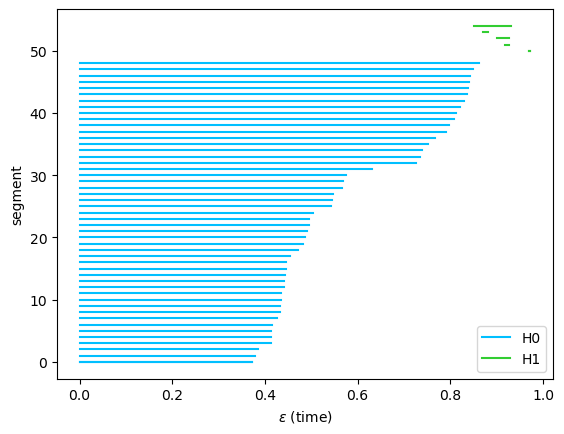

H0: num barcodes 75
max0,976Barcode 0 = 0.9417114
maxBarcode 0 = inf
middleBarcode 0 = 0.7077637
H1: num barcodes 32
max0,976Barcode 1 = 0.23580933
maxBarcode 1 = 0.23580933
middleBarcode 1 = 0.02532959


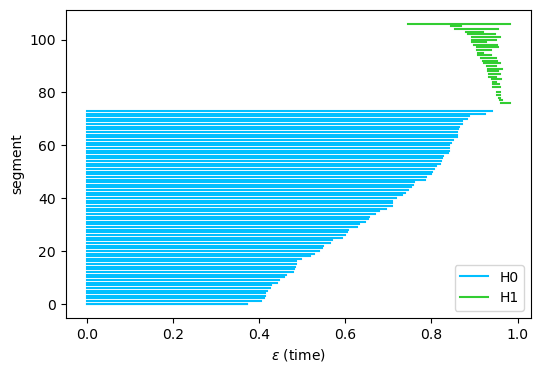

H0: num barcodes 93
max0,976Barcode 0 = 0.8745117
maxBarcode 0 = inf
middleBarcode 0 = 0.6982422
H1: num barcodes 66
max0,976Barcode 1 = 0.15765381
maxBarcode 1 = 0.20025635
middleBarcode 1 = 0.0418396


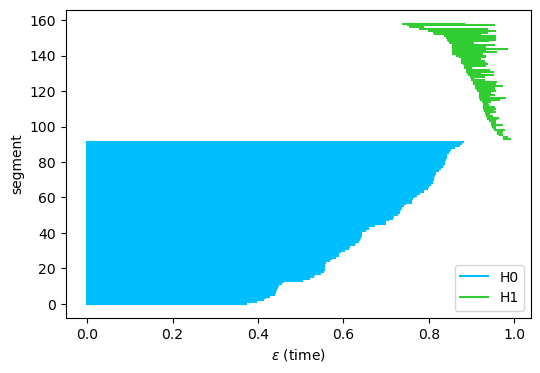

H0: num barcodes 59
max0,976Barcode 0 = 0.89538574
maxBarcode 0 = inf
middleBarcode 0 = 0.62353516
H1: num barcodes 7
max0,976Barcode 1 = 0.08972168
maxBarcode 1 = 0.08972168
middleBarcode 1 = 0.020965576


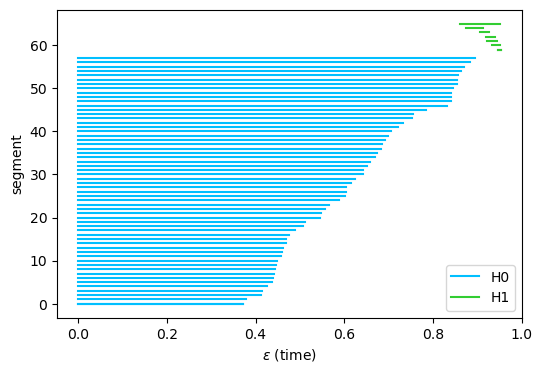

H0: num barcodes 23
max0,976Barcode 0 = inf
maxBarcode 0 = inf
middleBarcode 0 = 0.54541016
H1: num barcodes 0


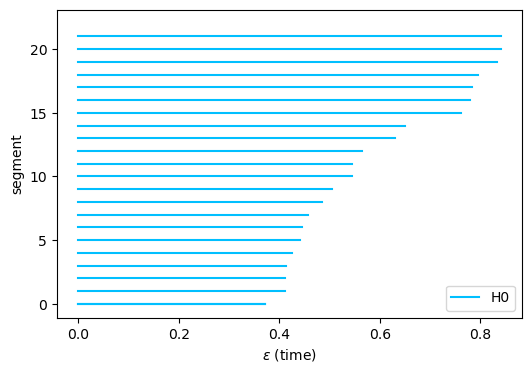

In [178]:
for seq in range(5):
    dgms = results14[('MBPP/14', 0, seq, 15, 27)][4]
    plot_barcodes([dgms['dgms'][0], dgms['dgms'][1]])

### Prompt & Generation len

In [ ]:
def prepare_features_test():
    all_features = []

    for task_num in range(10, 510):
        features = []
        task_id = 'MBPP/%d' % task_num
        for seed in range(1):
            for seq in range(5):

                prompt_len = results[(task_id, 0, 0, 0, 0)][0]
                answer_len = results[(task_id, seed, seq, 0, 0)][1] - prompt_len
                f_sample = [prompt_len, answer_len]
                                
                #for layer in range(32):
                #    for head in range(32):
                #        f = results[(task_id, seed, seq, layer, head)]
                #        f = [f[2] / prompt_len, f[3] / answer_len, f[4][0] / prompt_len, f[4][1] / prompt_len, f[5][0] / answer_len , f[5][1] / answer_len]
                #        f_sample.extend(f)
                #        
                all_features.append(f_sample)
    
    return all_features

In [ ]:
X2 = prepare_features_test()

In [ ]:
X2 = np.array(X2)

In [ ]:
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
fig = plt.figure(figsize=(5, 2.5))

c1 = Counter()
c_all = Counter()
fnum = 1

N_BINS = 10
data = X2[:, fnum]
est = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform')
est.fit(data[..., np.newaxis])
data = est.transform(data[..., np.newaxis])
data = data[:, 0]

inv_data = est.inverse_transform(np.arange(N_BINS)[..., np.newaxis])

print(data.shape)

for i in range(N_BINS):
    c1[i] = 0
    c_all[i] = 0

for elem in zip(data, Y):
    k, y = elem
    #k = min(k, 20)
    
    c1[k] += y
    c_all[k] += 1

plt.plot(inv_data[:, 0], [c1[x] / c_all[x] if c_all[x] else 0. for x in sorted(c1.keys())], 'o-', label = 'Probability of correctness', markersize = 2, alpha = 1)
plt.xlabel('Generation length, tokens')
#plt.ylabel('Probability of correctness')
#plt.legend(loc="upper left", bbox_to_anchor=(1.01,1.05))
plt.legend()
#plt.ylim((0, 0.3))
#sticks = [str(x) for x in list(range(0, 22, 2))]
#_ = plt.xticks(list(range(0, 22, 2)))
_ = plt.xticks(ticks = inv_data[:, 0], labels = [int(x) for x in inv_data[:, 0]])